# **IMPORT IMPORTANT LIBRARIES**

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pathlib
import urllib.request
import seaborn as sns
import shutil
# from google.colab import files
from shutil import copyfile
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from collections import Counter

import PIL
import PIL.Image
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import load_model

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# **SET HYPERPARAMETER**

In [2]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS = 30

# **DATA PIPELINING**

# **Extract**

In [3]:
# Mengunduh dataset dari GitHub dengan git clone
# !git clone https://github.com/zidan2808/ART-DATASETS.git

# Mengatur path ke folder dataset
dataset_dir = 'NEW ART DATASETS/ARTSCAPE'

# Buat direktori baru untuk menyimpan gambar yang telah diproses
preprocessed_dir = 'preprocessed_art'
if not os.path.exists(preprocessed_dir):
    os.makedirs(preprocessed_dir)

In [4]:
# Fungsi untuk mendapatkan daftar kelas dan jumlah masing-masing kelas
def get_class_distribution(dataset_dir):
    class_counts = Counter()

    # Loop melalui subdirektori dalam dataset_dir
    for root, dirs, files in os.walk(dataset_dir):
        for dir_name in dirs:
            class_dir = os.path.join(root, dir_name)
            num_images = len([f for f in os.listdir(class_dir)
                             if os.path.isfile(os.path.join(class_dir, f))])
            # Nama kelas diambil dari nama subdirektori terakhir
            class_name = os.path.basename(class_dir)
            class_counts[class_name] += num_images

    return class_counts


# Mendapatkan jumlah masing-masing kelas
class_counts = get_class_distribution(dataset_dir)

# Menghitung total jumlah kelas dan total jumlah file
num_classes = len(class_counts)
total_file_count = sum(class_counts.values())

# Membuat DataFrame dari hasil penghitungan
class_counts_df = pd.DataFrame.from_dict(
    class_counts, orient='index', columns=['Jumlah'])
class_counts_df.index.name = 'Genre'
class_counts_df.reset_index(inplace=True)

# Menampilkan tabel
print(class_counts_df)

# Menampilkan total jumlah kelas dan total jumlah file
print(f"\nTotal Jenis Genre Seni: {num_classes}")
print(f"Total Jumlah FIle: {total_file_count}")

               Genre  Jumlah
0           Abstract     438
1             Cubism     500
2            Dadaism     501
3   Neo-Expresionism     201
4            Nouveau     500
5            Pop Art     500
6  Post-Impresionism     333
7            Realism     500
8        Renaissance     500
9         Surrealism     500

Total Jenis Genre Seni: 10
Total Jumlah FIle: 4473


In [5]:
# Fungsi untuk mendapatkan daftar kelas dan jumlah masing-masing kelas
def get_class_distribution(dataset_dir):
    class_counts = Counter()
    extension_counts = Counter()

    # Loop melalui subdirektori dalam dataset_dir
    for root, dirs, files in os.walk(dataset_dir):
        for dir_name in dirs:
            class_dir = os.path.join(root, dir_name)
            num_images = len([f for f in os.listdir(class_dir)
                             if os.path.isfile(os.path.join(class_dir, f))])
            # Nama kelas diambil dari nama subdirektori terakhir
            class_name = os.path.basename(class_dir)
            class_counts[class_name] += num_images

            # Menghitung jumlah file berdasarkan ekstensi
            for file in os.listdir(class_dir):
                if os.path.isfile(os.path.join(class_dir, file)):
                    file_extension = os.path.splitext(file)[1].lower()
                    extension_counts[file_extension] += 1

    return class_counts, extension_counts


# Mendapatkan jumlah masing-masing kelas dan ekstensi file
class_counts, extension_counts = get_class_distribution(dataset_dir)

# Membuat DataFrame dari hasil penghitungan ekstensi
extension_counts_df = pd.DataFrame.from_dict(
    extension_counts, orient='index', columns=['Jumlah'])
extension_counts_df.index.name = 'Ekstensi'
extension_counts_df.reset_index(inplace=True)

# Menampilkan tabel
print(extension_counts_df)

  Ekstensi  Jumlah
0     .jpg    4224
1     .png     243
2     .ini       1
3     .gif       4
4    .jpeg       1


# **Transform**

In [6]:
# def preprocess_and_save_image(image_path, save_path):
#     try:
#         with Image.open(image_path) as img:
#             # Jika gambar dalam mode CMYK, konversi ke RGB
#             if img.mode == 'CMYK':
#                 img = img.convert('RGB')

#             # Mengubah ukuran gambar
#             img = img.resize((IMG_HEIGHT, IMG_WIDTH))

#             # Menyimpan gambar sebagai PNG
#             img.save(save_path, 'PNG')
#     except OSError as e:
#         print(f"Error processing image {image_path}: {e}")


# # Menelusuri direktori dataset dan memproses gambar
# for root, dirs, files in os.walk(dataset_dir):
#     for file in files:
#         if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', '.tiff', '.gif')):
#             image_path = os.path.join(root, file)
#             relative_path = os.path.relpath(image_path, dataset_dir)
#             save_path = os.path.join(
#                 preprocessed_dir, os.path.splitext(relative_path)[0] + '.png')

#             # Membuat direktori jika belum ada
#             os.makedirs(os.path.dirname(save_path), exist_ok=True)

#             # Memproses dan menyimpan gambar
#             preprocess_and_save_image(image_path, save_path)

# print("Semua gambar telah diproses dan disimpan sebagai PNG.")

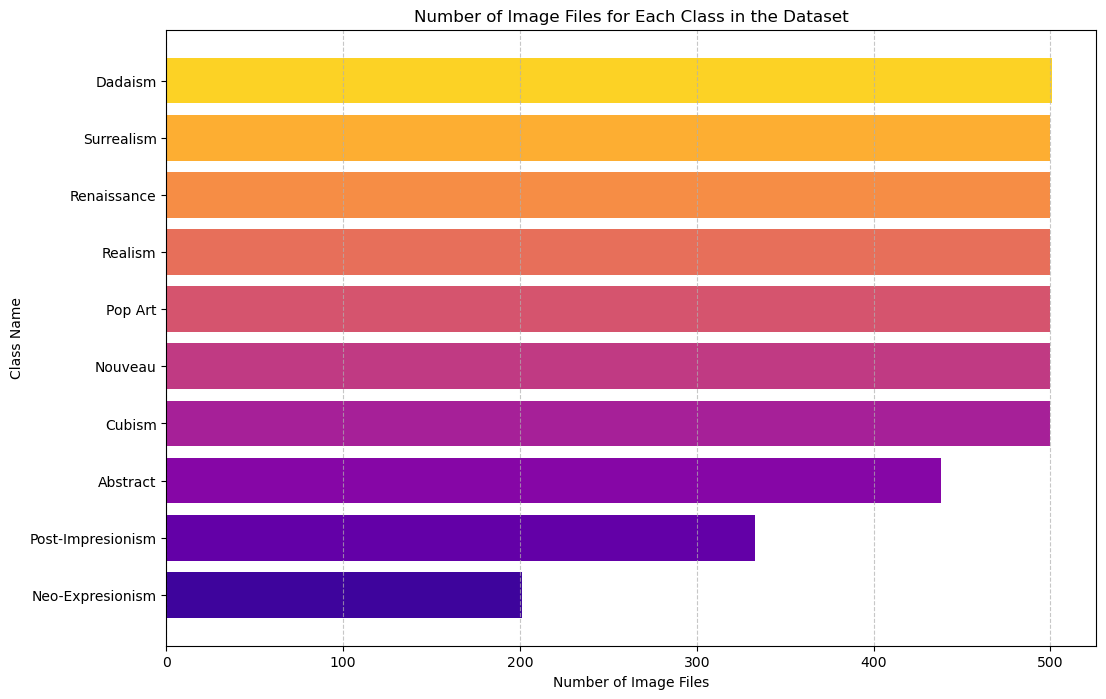

In [7]:
# Mengurutkan kelas berdasarkan jumlah file
sorted_class_counts = sorted(
    class_counts.items(), key=lambda x: x[1], reverse=False)
sorted_class_names = [item[0] for item in sorted_class_counts]
sorted_file_counts = [item[1] for item in sorted_class_counts]

# Setel palet warna berdasarkan jumlah kelas
palette = sns.color_palette("plasma", len(sorted_class_counts))

# Membuat plot
plt.figure(figsize=(12, 8))
plt.barh(sorted_class_names, sorted_file_counts, color=palette)
plt.xlabel('Number of Image Files')
plt.ylabel('Class Name')
plt.title('Number of Image Files for Each Class in the Dataset')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Menampilkan plot
plt.show()

# **Load**

In [8]:
# Direktori untuk menyimpan dataset validasi
new_validation_dir = 'validation_images'
os.makedirs(new_validation_dir, exist_ok=True)


def copy_files(file_list, target_dir):
    for file_path in file_list:
        class_name = os.path.basename(os.path.dirname(file_path))
        target_class_dir = os.path.join(target_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        shutil.copy(file_path, target_class_dir)

In [9]:
# Menggunakan ImageDataGenerator untuk memuat gambar yang telah diproses
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    # rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = datagen.flow_from_directory(
    preprocessed_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Ukuran gambar
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Gunakan 'categorical' untuk beberapa kelas
    subset='training'
)

validation_dataset = datagen.flow_from_directory(
    preprocessed_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Ukuran gambar
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Gunakan 'categorical' untuk beberapa kelas
    subset='validation'
)

Found 3579 images belonging to 10 classes.
Found 893 images belonging to 10 classes.


In [10]:
class_indices = train_dataset.class_indices
num_classes = len(class_indices)
print(f"Jumlah kelas: {num_classes}")
print("Label kelas:", class_indices)

Jumlah kelas: 10
Label kelas: {'Abstract': 0, 'Cubism': 1, 'Dadaism': 2, 'Neo-Expresionism': 3, 'Nouveau': 4, 'Pop Art': 5, 'Post-Impresionism': 6, 'Realism': 7, 'Renaissance': 8, 'Surrealism': 9}


In [11]:
class_indices = validation_dataset.class_indices
num_classes = len(class_indices)
print(f"Jumlah kelas: {num_classes}")
print("Label kelas:", class_indices)

Jumlah kelas: 10
Label kelas: {'Abstract': 0, 'Cubism': 1, 'Dadaism': 2, 'Neo-Expresionism': 3, 'Nouveau': 4, 'Pop Art': 5, 'Post-Impresionism': 6, 'Realism': 7, 'Renaissance': 8, 'Surrealism': 9}


In [12]:

# Salin gambar-gambar dari dataset validasi ke direktori baru
validation_file_paths = [validation_dataset.filepaths[i]
                         for i in range(validation_dataset.samples)]
copy_files(validation_file_paths, new_validation_dir)

print(f"Total {len(validation_file_paths)} files copied to {new_validation_dir}")

Total 893 files copied to validation_images


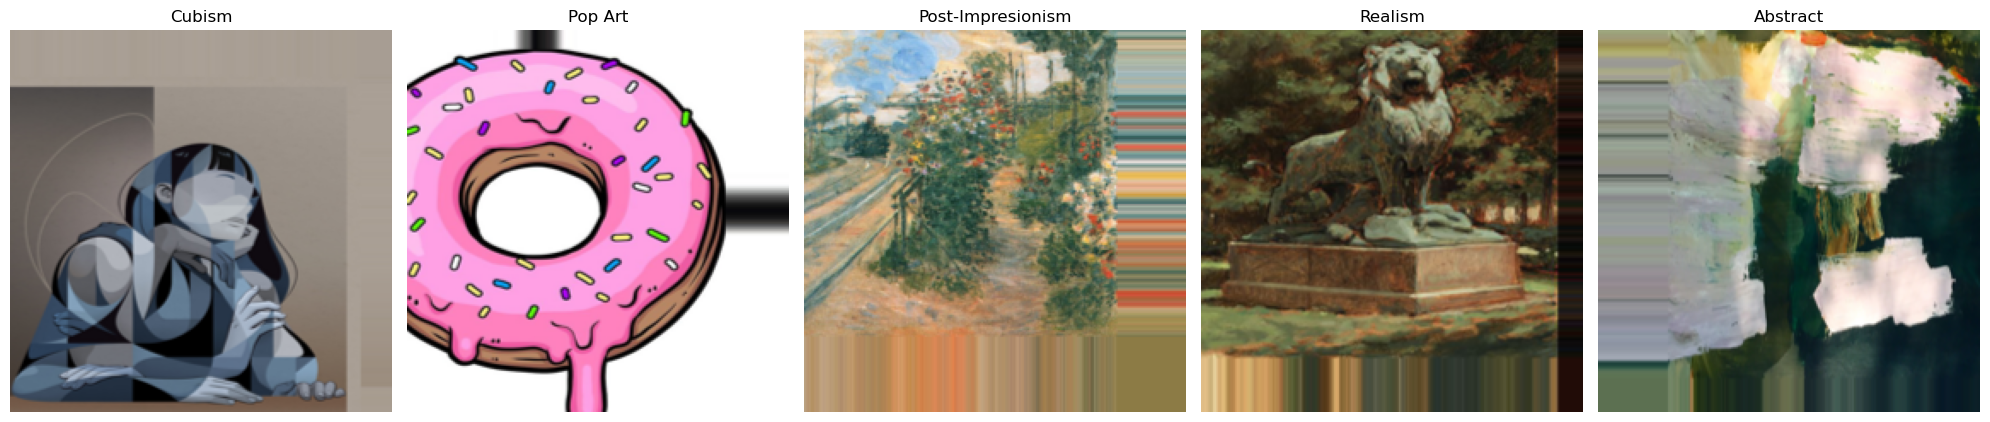

In [13]:
# Menampilkan beberapa contoh gambar
def plot_images(images_arr, labels_arr, class_indices, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        label = list(class_indices.keys())[
            list(class_indices.values()).index(np.argmax(lbl))]
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Mendapatkan batch gambar dan label
images, labels = next(train_dataset)

# Menampilkan 5 contoh gambar
plot_images(images[:5], labels[:5], class_indices, num_images=5)

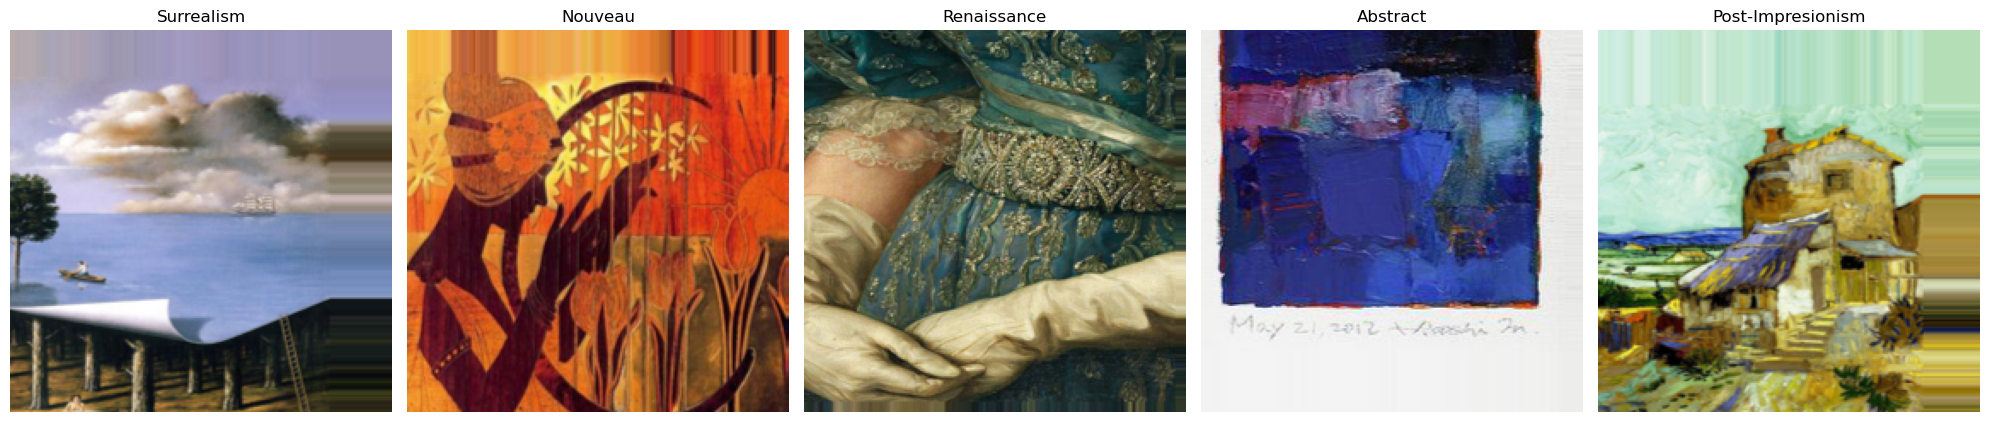

In [14]:
# Mendapatkan batch gambar dan label
images, labels = next(validation_dataset)

# Menampilkan 5 contoh gambar
plot_images(images[:5], labels[:5], class_indices, num_images=5)

In [15]:
# weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
# urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                include_top=False,
                                weights='imagenet')

# load pre-trained weights
pre_trained_model.load_weights(weights_file)

# freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False


# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [16]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(pre_trained_model.input, x)

In [17]:
# compile the model
model.compile(optimizer=RMSprop(lr=0.00001),
              loss='categorical_crossentropy',
              metrics=['acc'])

# train the model (adjust the number of epochs from 1 to improve performance)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    verbose=1)

Epoch 1/30
112/112 [==============================] - 45s 345ms/step - loss: 1.5426 - acc: 0.5211 - val_loss: 1.1628 - val_acc: 0.6327
Epoch 2/30
112/112 [==============================] - 37s 328ms/step - loss: 0.9103 - acc: 0.7200 - val_loss: 0.9288 - val_acc: 0.7178
Epoch 3/30
112/112 [==============================] - 37s 328ms/step - loss: 0.6903 - acc: 0.7871 - val_loss: 0.8120 - val_acc: 0.7324
Epoch 4/30
112/112 [==============================] - 36s 323ms/step - loss: 0.5862 - acc: 0.8175 - val_loss: 0.7951 - val_acc: 0.7380
Epoch 5/30
112/112 [==============================] - 37s 328ms/step - loss: 0.5124 - acc: 0.8396 - val_loss: 0.7761 - val_acc: 0.7458
Epoch 6/30
112/112 [==============================] - 36s 324ms/step - loss: 0.4656 - acc: 0.8572 - val_loss: 0.7371 - val_acc: 0.7615
Epoch 7/30
112/112 [==============================] - 38s 337ms/step - loss: 0.4137 - acc: 0.8709 - val_loss: 0.7352 - val_acc: 0.7716
Epoch 8/30
112/112 [==============================] - 3

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

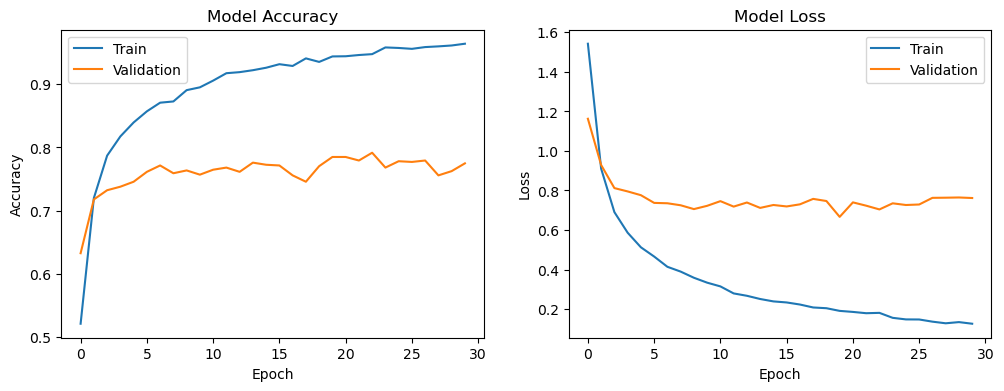

In [19]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [20]:
score = model.evaluate(validation_dataset, verbose=0)
print("Accuracy: {}%, Loss:{}".format(score[1]*100, score[0]))

Accuracy: 76.59574747085571%, Loss:0.7710856199264526


**SAVE MODEL**

In [21]:
# Save the model to a .h5 file
model.save('new_art_genre_classification.h5')

**PREDIKSI GAMBAR DI VALIDATION IMAGES**

In [22]:
class_indices = validation_dataset.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

In [23]:
def display_images(images, predictions, true_labels, title, class_names, num_images=9):
    plt.figure(figsize=(16, 16))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        color = 'green' if predictions[i] == true_labels[i] else 'red'
        plt.title("True: {}\nPred: {}".format(
            class_names[true_labels[i]], class_names[predictions[i]]), color=color)
        plt.axis("off")
    plt.suptitle(title, size=20)
    plt.show()

1/1 [==============================] - 1s 1s/step


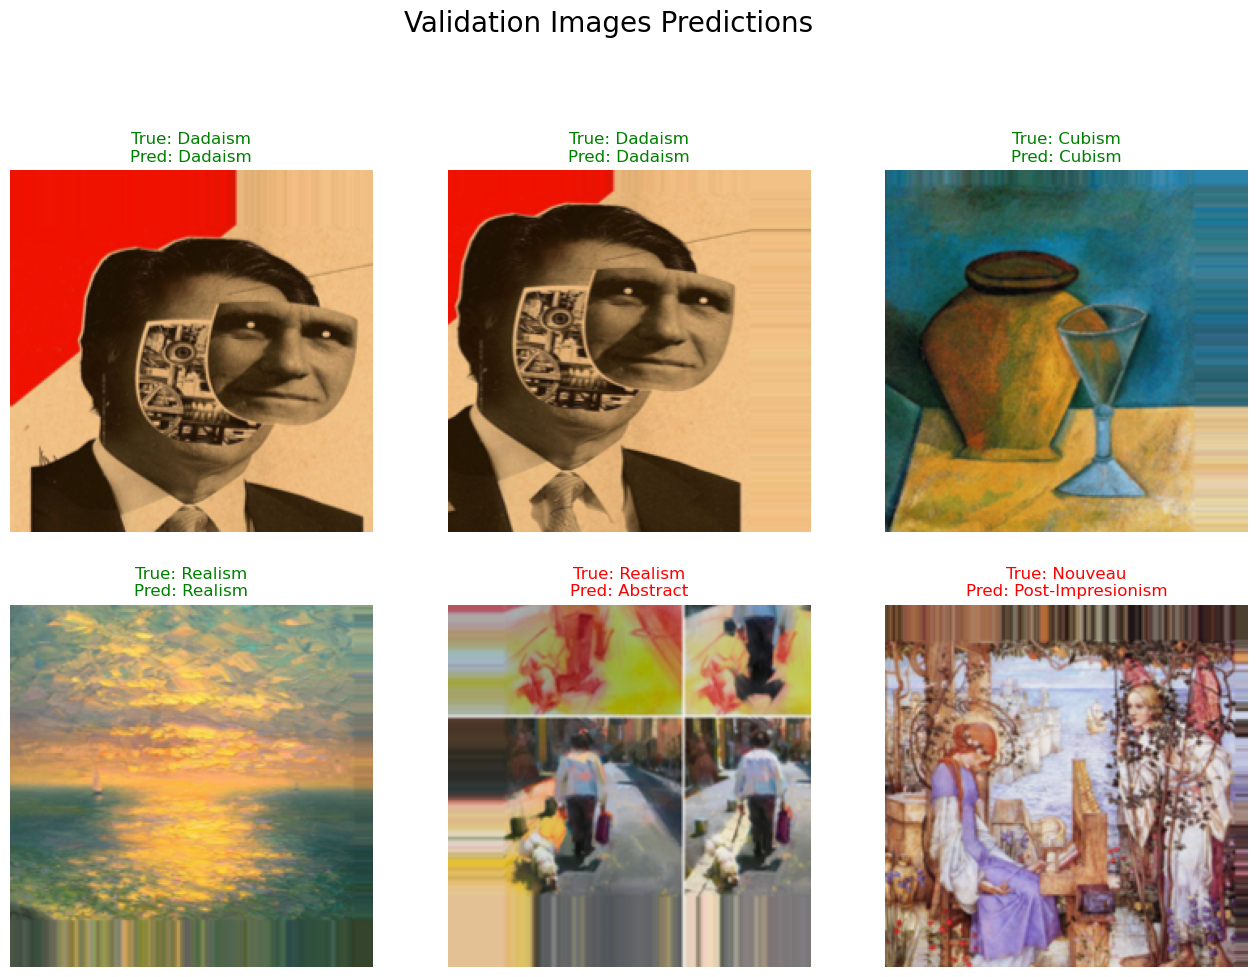

In [24]:
# Kumpulkan gambar, prediksi, dan label sebenarnya dari dataset validasi
def collect_validation_data(num_images):
    validation_images = []
    validation_labels = []

    # Reset iterator sebelum loop
    validation_dataset.reset()

    # Collect a manageable number of images and labels
    for i in range(num_images):
        images, labels = validation_dataset.next()
        validation_images.append(images[0])
        validation_labels.append(np.argmax(labels, axis=-1)[0])

    validation_images = np.array(validation_images)
    validation_labels = np.array(validation_labels)

    return validation_images, validation_labels


# Tentukan jumlah gambar yang ingin diplot
num_images = 6  # Ubah nilai ini sesuai kebutuhan

# Kumpulkan data validasi
validation_images, validation_labels = collect_validation_data(num_images)

# Prediksi
probabilities = model.predict(validation_images, batch_size=num_images)
predicted_classes = np.argmax(probabilities, axis=1)

# Tampilkan gambar dengan prediksi dan label sebenarnya
display_images(validation_images, predicted_classes,
               validation_labels, "Validation Images Predictions", idx_to_class, num_images)

In [25]:
# Load the model (replace 'your_model.h5' with your actual model file)
model = load_model('new_art_genre_classification.h5')

# Function to load class labels from the train_generator


def load_class_labels(generator):
    class_indices = generator.class_indices
    return {v: k for k, v in class_indices.items()}


# Assuming 'validation_dataset' is already defined and used to load the class labels
class_labels = load_class_labels(validation_dataset)

# Specify the directory containing images
image_directory = '.\images'

# Loop through the files in the directory
for filename in os.listdir(image_directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Predicting images
        path = os.path.join(image_directory, filename)
        img = load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        x = img_to_array(img)
        x /= 255.0
        x = np.expand_dims(x, axis=0)

        image_tensor = np.vstack([x])
        classes = model.predict(image_tensor)

        # Get the indices of the top 3 classes with the highest probabilities
        top_3_indices = np.argsort(classes[0])[-3:][::-1]

        print(f"Predictions for {filename}:")
        for i in top_3_indices:
            class_name = class_labels[i]
            probability = classes[0][i]
            print(f"Class: {class_name}, Probability: {probability:.2f}")

1/1 [==============================] - 1s 919ms/step
Predictions for abstract.png:
Class: Post-Impresionism, Probability: 0.99
Class: Realism, Probability: 0.00
Class: Surrealism, Probability: 0.00


**UNGGAH FILE DI GOOGLE COLAB**

In [26]:
# import numpy as np
# from google.colab import files
# from tensorflow.keras.utils import load_img, img_to_array

# # Fungsi untuk memuat label kelas dari train_generator


# def load_class_labels(generator):
#     class_indices = generator.class_indices
#     return {v: k for k, v in class_indices.items()}


# class_labels = load_class_labels(validation_dataset)

# # Mengunggah file
# uploaded = files.upload()

# for fn in uploaded.keys():

#     # predicting images
#     path = '/content/' + fn
#     img = load_img(path, target_size=(150, 150))
#     x = img_to_array(img)
#     x /= 255.0
#     x = np.expand_dims(x, axis=0)

#     image_tensor = np.vstack([x])
#     classes = model.predict(image_tensor)

#     # Mendapatkan indeks kelas dengan probabilitas tertinggi
#     top_3_indices = np.argsort(classes[0])[-3:][::-1]

#     print(f"Predictions for {fn}:")
#     for i in top_3_indices:
#         class_name = class_labels[i]
#         probability = classes[0][i]
#         print(f"Class: {class_name}, Probability: {probability:.2f}")